In [ ]:
!pip install omnixai

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from omnixai.explainers.vision import ContrastiveExplainer, counterfactual
from omnixai.data.image import Image
from tensorflow.keras.models import Model, load_model
import numpy as np

In [ ]:
path_prefix = '/content/drive/My Drive/Courses/DL BU/kaggle_cem/kaggle/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load your data
x_train = np.load(path_prefix + 'train_data_kaggle.npy')
y_train = np.load(path_prefix + 'train_labels_kaggle.npy')
x_test = np.load(path_prefix + 'test_data_kaggle.npy')
y_test = np.load(path_prefix + 'test_labels_kaggle.npy')

In [ ]:
# Load models
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),

      tf.keras.metrics.AUC(name='auc')
]

cnn = load_model('/content/drive/My Drive/Courses/DL BU/kaggle_cem/kaggle_model.h5', compile=False)
cnn.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

In [ ]:
# test
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.91845703125


In [ ]:
# Making the data into an image
x_train = Image(x_train.astype('float32'), batched=True)
x_test = Image(x_test.astype('float32'), batched=True)

# explaining
preprocess = lambda x: x.to_numpy()

In [ ]:
cf = counterfactual.ce.CounterfactualExplainer(cnn, preprocess, mode='classification', c=1000.0,
                                                                    kappa=900.0, binary_search_steps=5, learning_rate=0.1,
                                                                    num_iterations=10, grad_clip=10.0)

In [ ]:
explanations = cf.explain(x_train[0:5])

print("done")

Binary step: 5 |████████████████████████████████████----| 90.0% done


In [ ]:
image_dict = explanations.get_explanations()[0]
print(image_dict.keys())

In [ ]:
original_image = image_dict['image']
original_label = image_dict['label']
counterfactual_image = image_dict['cf']
counterfactual_label = image_dict['cf_label']

In [ ]:
label_descriptions = {
    0: 'Mild Demented',
    1: 'Moderate Demented',
    2: 'Non Demented',
    3: 'Very Mild Demented'
}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def binarize_image(image, threshold= 0.9):

    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    binary_image = (normalized_image > threshold).astype(np.uint8)
    return binary_image

In [ ]:
original_gray = np.mean(original_image, axis=-1)
counterfactual_gray = np.mean(counterfactual_image, axis=-1)

direct_gray_difference = original_gray - counterfactual_gray


original_gray_binarized = binarize_image(original_gray)
counterfactual_gray_binarized = binarize_image(counterfactual_gray)

direct_gray_difference_binarized = original_gray_binarized - counterfactual_gray_binarized

# Calculate percentiles for robust color limit setting
lower_percentile = np.percentile(direct_gray_difference, 5)  # 5th percentile
upper_percentile = np.percentile(direct_gray_difference, 95)  # 95th percentile

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Display the original image
axes[0].imshow(original_gray, cmap='gray')
axes[0].set_title(f'Original Image (OI)\n{label_descriptions.get(original_label, "Unknown Label")}')
axes[0].axis('off')  # Turn off axis

# Display the counterfactual image
axes[1].imshow(counterfactual_gray, cmap='gray')
axes[1].set_title(f'Counterfactual Image(CI)\n{label_descriptions.get(counterfactual_label, "Unknown Label")}')
axes[1].axis('off')  # Turn off axis

axes[2].imshow(direct_gray_difference_binarized, cmap='gray')
axes[2].set_title(f'Difference Image (OI-CI)')
axes[2].axis('off')  # Turn off axis

# Visualize the direct grayscale difference
im = axes[3].imshow(direct_gray_difference_binarized, cmap='bwr', clim=(lower_percentile, upper_percentile))
axes[3].set_title("Difference Image in color intensity")
axes[3].axis('off')  # Turn off axis

# Adjust the colorbar to match the height of the images
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes[3])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Difference in intensity')

# Adjust layout to fit
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Define your base directory where the images and CSV will be saved
base_directory = '/content/drive/My Drive/Courses/DL BU/kaggle_cem/kaggle/'

# Create directories for original and counterfactual images if they don't exist
original_images_dir = os.path.join(base_directory, 'original_images')
counterfactual_images_dir = os.path.join(base_directory, 'counterfactual_images')

os.makedirs(original_images_dir, exist_ok=True)
os.makedirs(counterfactual_images_dir, exist_ok=True)

# Prepare a list to store label information
labels_info = []

In [ ]:
explanations = cf.explain(x_train[0:50])  # Assuming x_train is your dataset

Binary step: 5 |███████████████████████████████████████-| 98.0% 

In [ ]:
image_dict = explanations.get_explanations()  # Access the first explanation

In [ ]:
for i in range(5):

    original_image = image_dict[i]['image']
    original_label = image_dict[i]['label']
    counterfactual_image = image_dict[i]['cf']
    counterfactual_label = image_dict[i]['cf_label']

    # Save the original and counterfactual images to their respective directories
    original_image_path = os.path.join(original_images_dir, f'original_image_{i}.png')
    counterfactual_image_path = os.path.join(counterfactual_images_dir, f'counterfactual_image_{i}.png')

    original_gray = np.mean(original_image, axis=-1)
    counterfactual_gray = np.mean(counterfactual_image, axis=-1)

    original_gray_uint8 = (original_gray * 255).astype(np.uint8)
    counterfactual_gray_uint8 = (counterfactual_gray * 255).astype(np.uint8)

    # Create PIL Images from the grayscale arrays
    original_gray_image = Image.fromarray(original_gray_uint8, mode='L')
    counterfactual_gray_image = Image.fromarray(counterfactual_gray_uint8, mode='L')

    # Save the grayscale images
    original_gray_image.save(original_image_path)
    counterfactual_gray_image.save(counterfactual_image_path)

    # Create a list with the label information for each image
    labels_info = {'Image_Index': i, 'Original_Label': original_label, 'Counterfactual_Label': counterfactual_label}

    # Append the label information to a CSV file
    labels_csv_path = os.path.join(base_directory, 'labels_info.csv')
    if not os.path.exists(labels_csv_path):
        # If the CSV file does not exist, create it and write the header
        labels_df = pd.DataFrame(columns=['Image_Index', 'Original_Label', 'Counterfactual_Label'])
        labels_df.to_csv(labels_csv_path, index=False)

    # Append the label information to the existing CSV file
    labels_df = pd.read_csv(labels_csv_path)
    labels_df = labels_df.append(labels_info, ignore_index=True)
    labels_df.to_csv(labels_csv_path, index=False)

print("All images and labels have been saved.")

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


All images and labels have been saved.


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
direct_difference = counterfactual_gray - original_gray

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Base directory paths
original_images_base_dir = '/content/drive/MyDrive/Courses/DL BU/kaggle_cem/kaggle/original_images'
counterfactual_images_base_dir = '/content/drive/MyDrive/Courses/DL BU/kaggle_cem/kaggle/counterfactual_images'

# Lists to store the grayscale images and their differences
original_gray_images = []
counterfactual_gray_images = []
direct_differences = []

# Iterate over the files in the original images directory
for filename in sorted(os.listdir(original_images_base_dir)):
    if filename.startswith('original_image_') and filename.endswith('.png'):
        # Extract the image index from the filename
        image_index = filename[len('original_image_'):-len('.png')]

        # Construct the file paths
        original_image_path = os.path.join(original_images_base_dir, filename)
        counterfactual_image_path = os.path.join(counterfactual_images_base_dir, f'counterfactual_image_{image_index}.png')

        # Check if the counterfactual file exists
        if not os.path.exists(counterfactual_image_path):
            print(f"Counterfactual file missing for {filename}")
            continue

        # Open and convert images to grayscale
        original_image = Image.open(original_image_path).convert('L')
        counterfactual_image = Image.open(counterfactual_image_path).convert('L')

        original_array = np.array(original_image)
        counterfactual_array = np.array(counterfactual_image)

        # Calculate the direct pixel-wise difference
        direct_difference = original_array.astype(np.float32) - counterfactual_array.astype(np.float32)

        # Append to lists
        original_gray_images.append(original_array)
        counterfactual_gray_images.append(counterfactual_array)
        direct_differences.append(direct_difference)

# At this point, you have the images and their differences in the


In [ ]:
import pickle

# Assuming image_dict is your dictionary
with open('image_dict.pkl', 'wb') as file:
    pickle.dump(image_dict, file)


In [1]:
import pickle

# Load the dictionary from the pickle file
with open('image_dict.pkl', 'rb') as file:
    image_dict2 = pickle.load(file)

# image_dict now contains your data

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
label_descriptions = {
    0: 'Mild Demented',
    1: 'Moderate Demented',
    2: 'Non Demented',
    3: 'Very Mild Demented'
}

Changing the threshold to binarize changes pixel intensities you see below.

In [13]:
import numpy as np

def binarize_image(image, threshold= 0.9):

    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    binary_image = (normalized_image > threshold).astype(np.uint8)
    return binary_image

In [10]:
def plotter(a):

  original_image = image_dict2[a]['image']
  counterfactual_image = image_dict2[a]['cf']
  original_label = image_dict2[a]['label']
  counterfactual_label = image_dict2[a]['cf_label']

  original_gray = np.mean(original_image, axis=-1)
  counterfactual_gray = np.mean(counterfactual_image, axis=-1)

  direct_gray_difference = original_gray - counterfactual_gray


  original_gray_binarized = binarize_image(original_gray)
  counterfactual_gray_binarized = binarize_image(counterfactual_gray)

  direct_gray_difference_binarized = original_gray_binarized - counterfactual_gray_binarized

  # Calculate percentiles for robust color limit setting
  lower_percentile = np.percentile(direct_gray_difference, 5)  # 5th percentile
  upper_percentile = np.percentile(direct_gray_difference, 95)  # 95th percentile

  fig, axes = plt.subplots(1, 4, figsize=(15, 5))

  # Display the original image
  axes[0].imshow(original_gray, cmap='gray')
  axes[0].set_title(f'Original Image (OI)\n{label_descriptions.get(original_label, "Unknown Label")}')
  axes[0].axis('off')  # Turn off axis

  # Display the counterfactual image
  axes[1].imshow(counterfactual_gray, cmap='gray')
  axes[1].set_title(f'Counterfactual Image(CI)\n{label_descriptions.get(counterfactual_label, "Unknown Label")}')
  axes[1].axis('off')  # Turn off axis

  axes[2].imshow(direct_gray_difference_binarized, cmap='gray')
  axes[2].set_title(f'Difference Image (OI-CI)')
  axes[2].axis('off')  # Turn off axis

  # Visualize the direct grayscale difference
  im = axes[3].imshow(direct_gray_difference_binarized, cmap='bwr', clim=(lower_percentile, upper_percentile))
  axes[3].set_title("Difference Image in color intensity")
  axes[3].axis('off')  # Turn off axis

  # Adjust the colorbar to match the height of the images
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  divider = make_axes_locatable(axes[3])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(im, cax=cax)
  cbar.set_label('Difference in intensity')

  # Adjust layout to fit
  plt.tight_layout()

  # Show the plot
  plt.show()


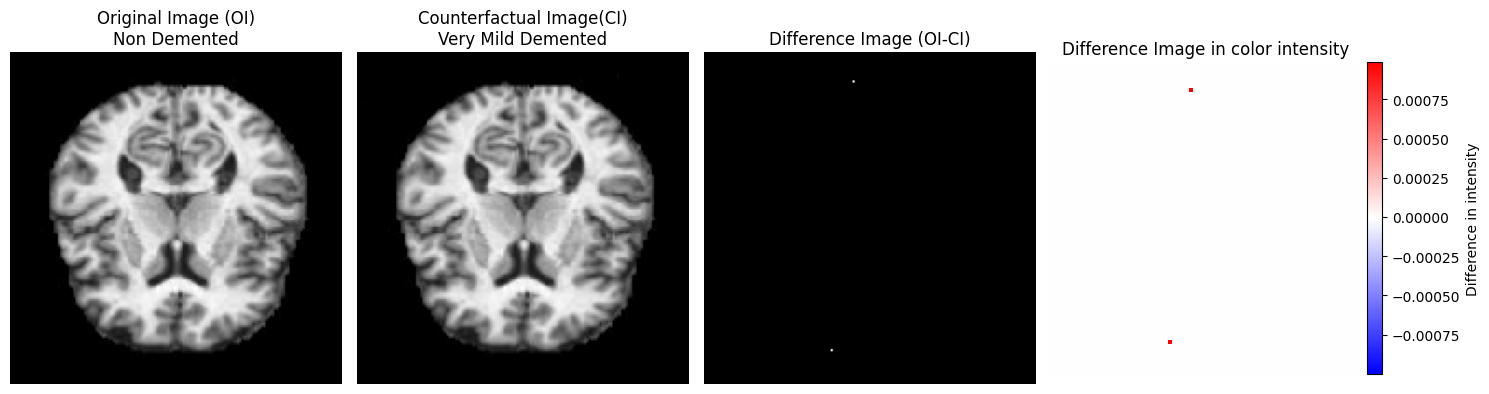

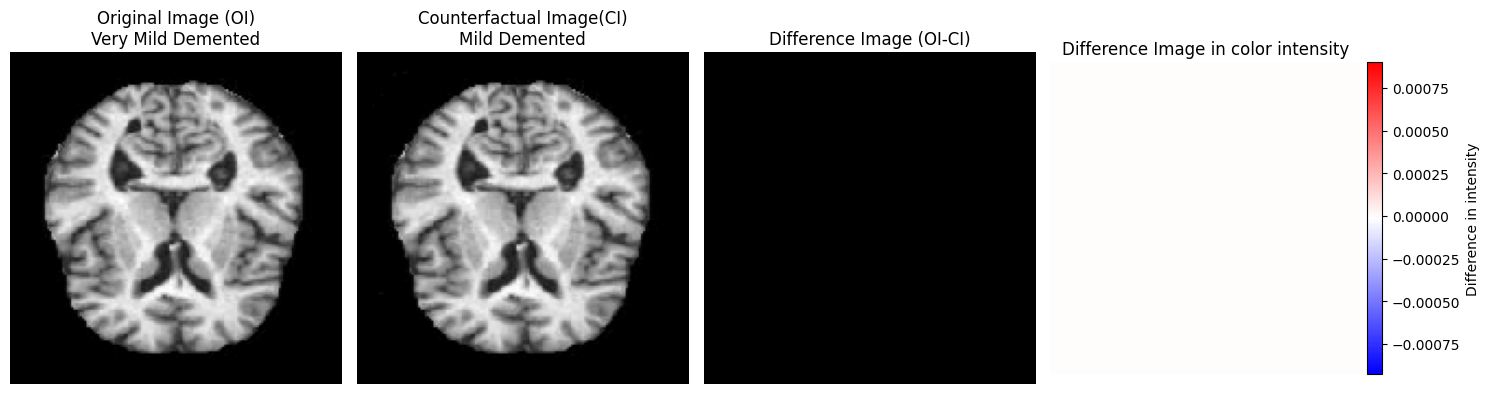

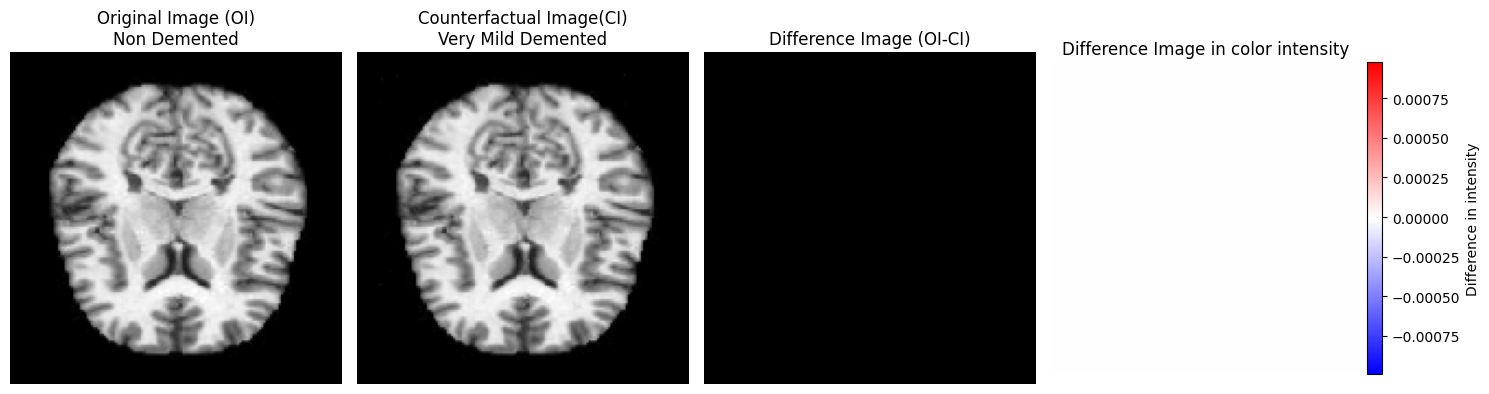

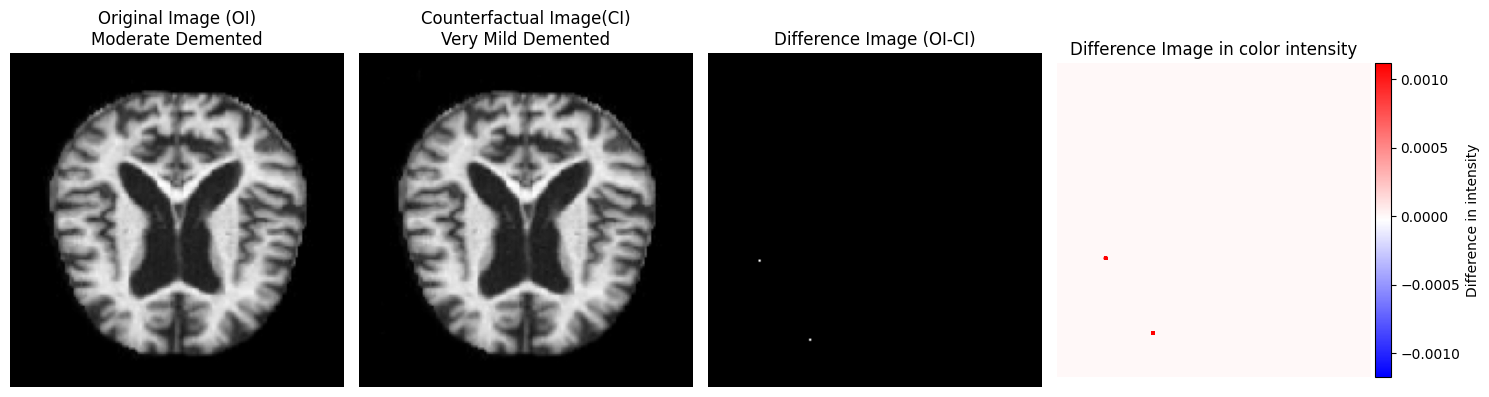

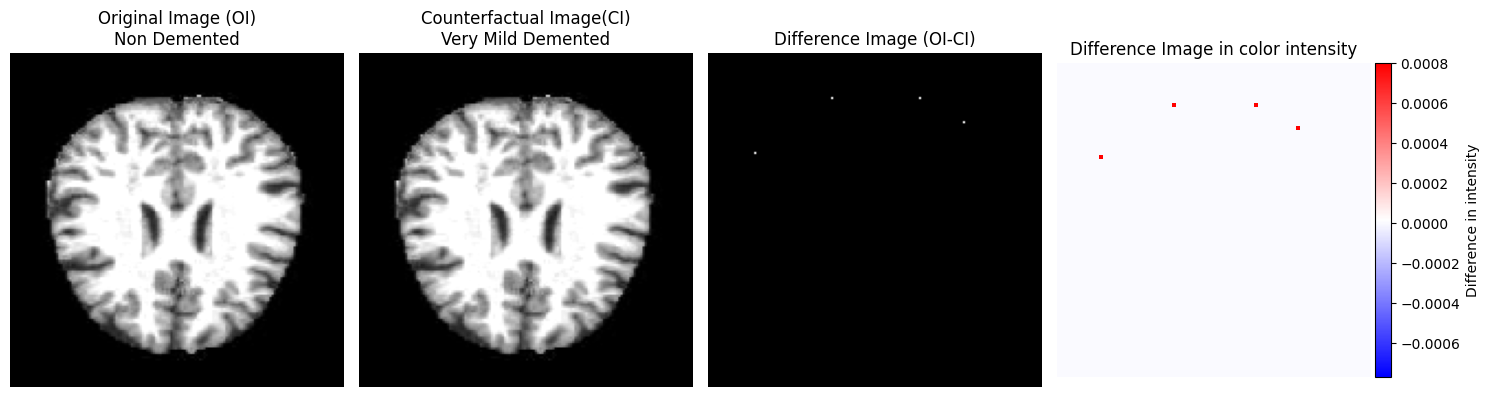

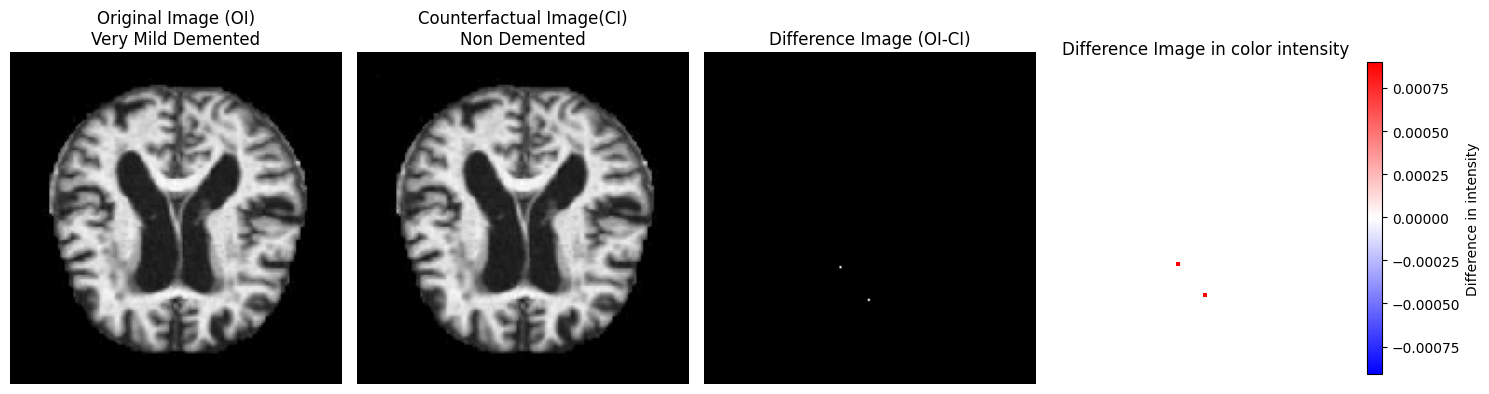

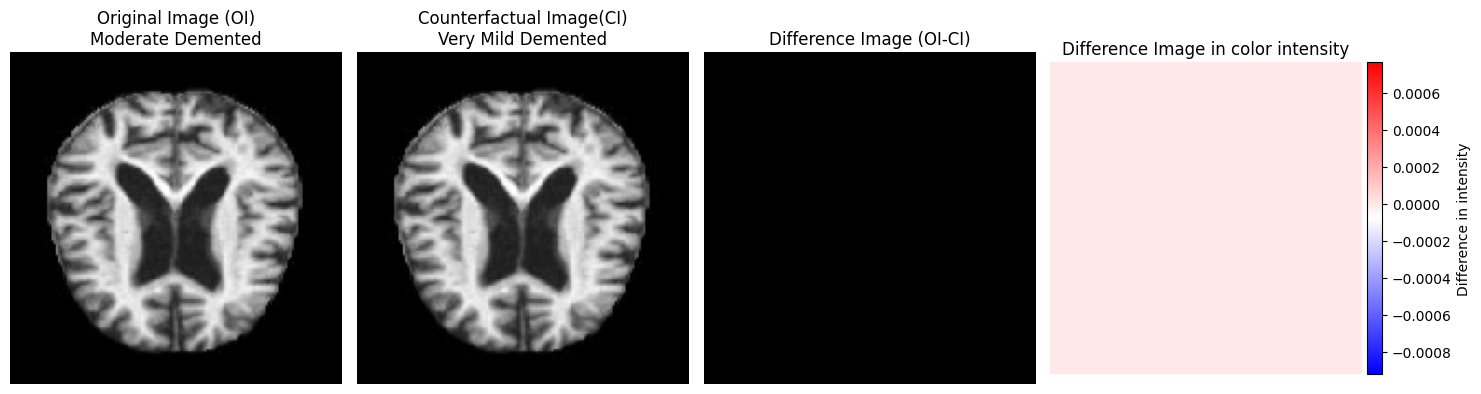

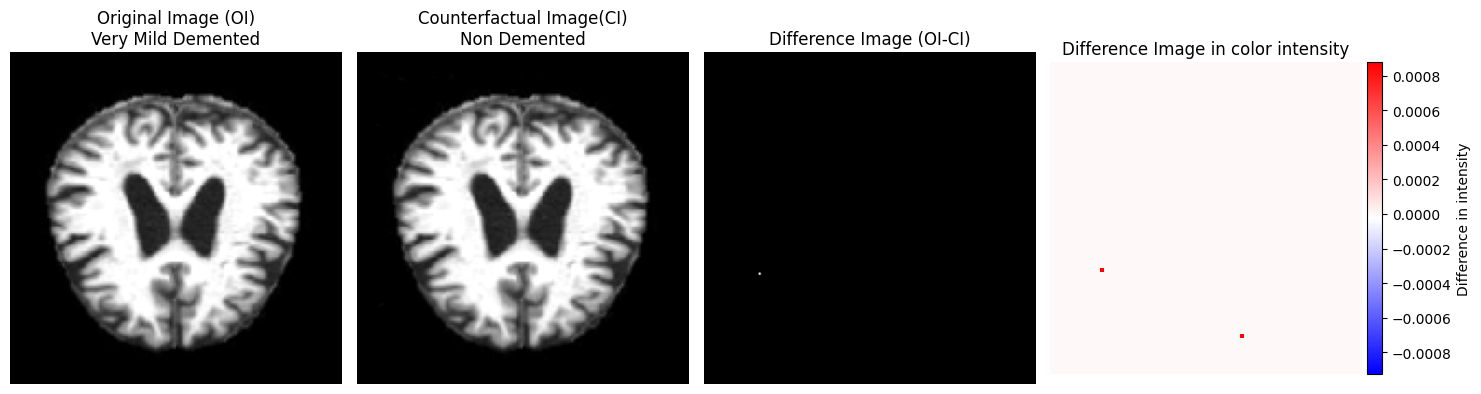

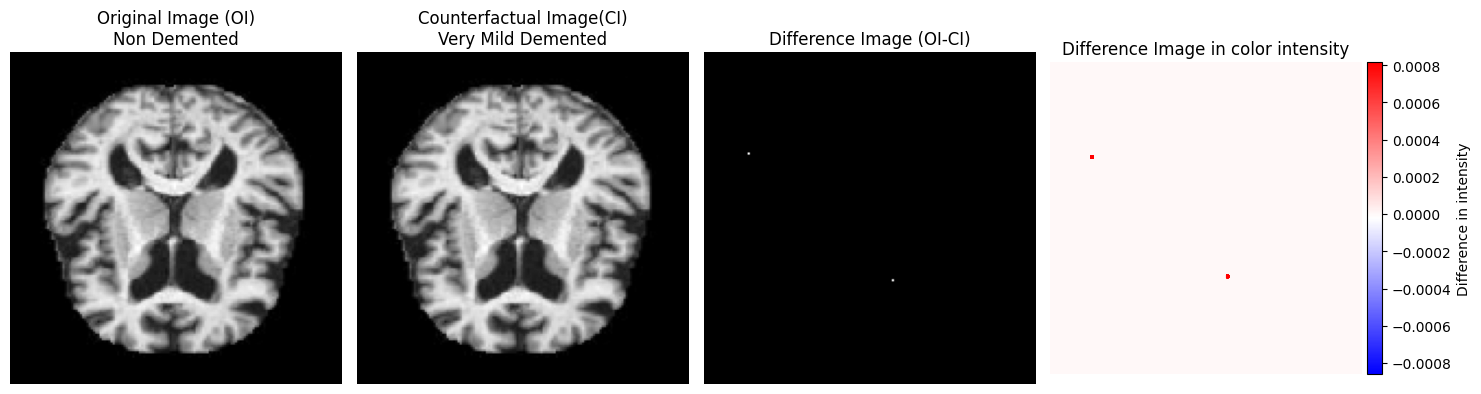

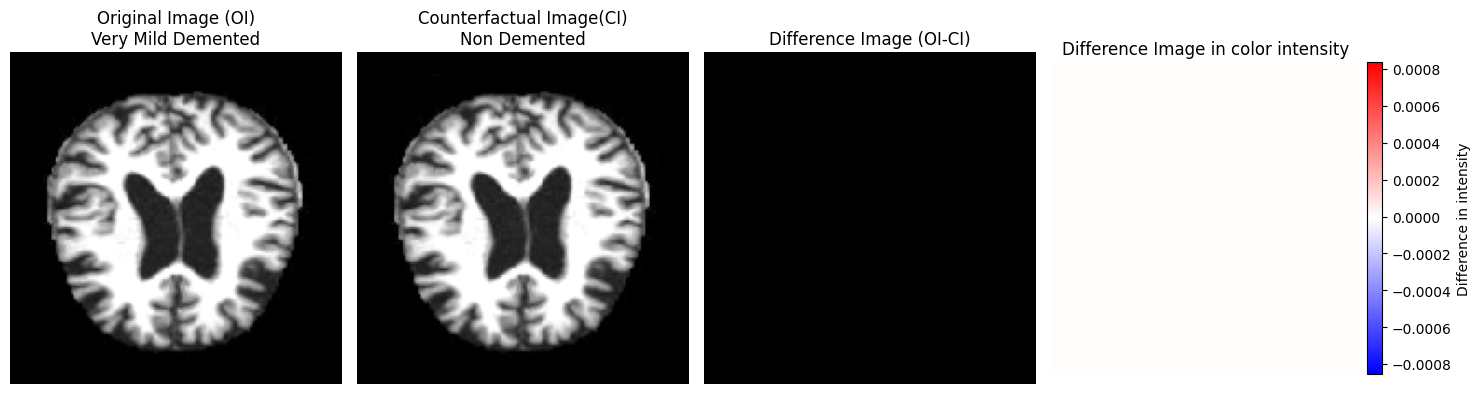

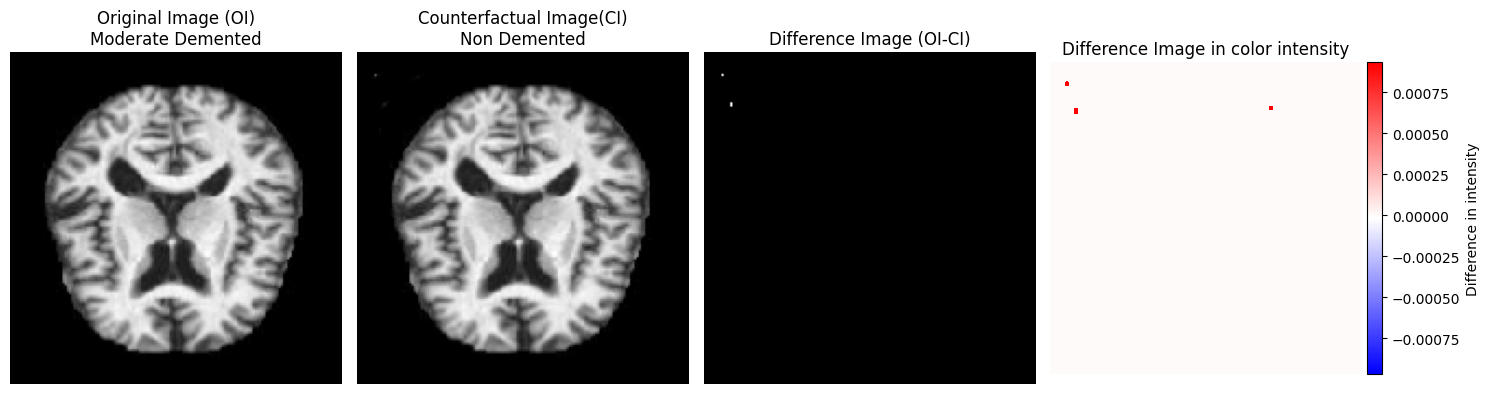

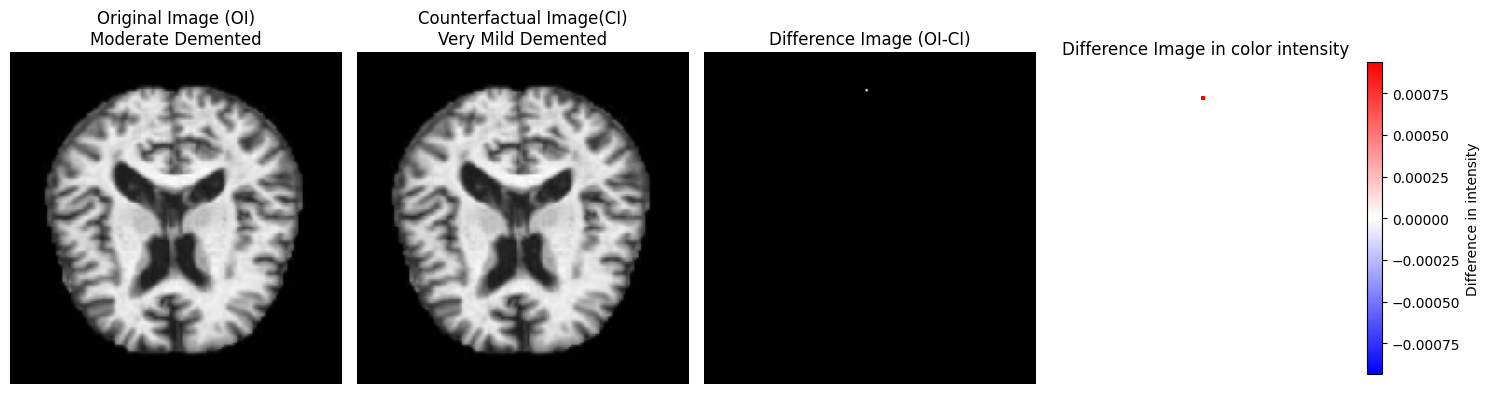

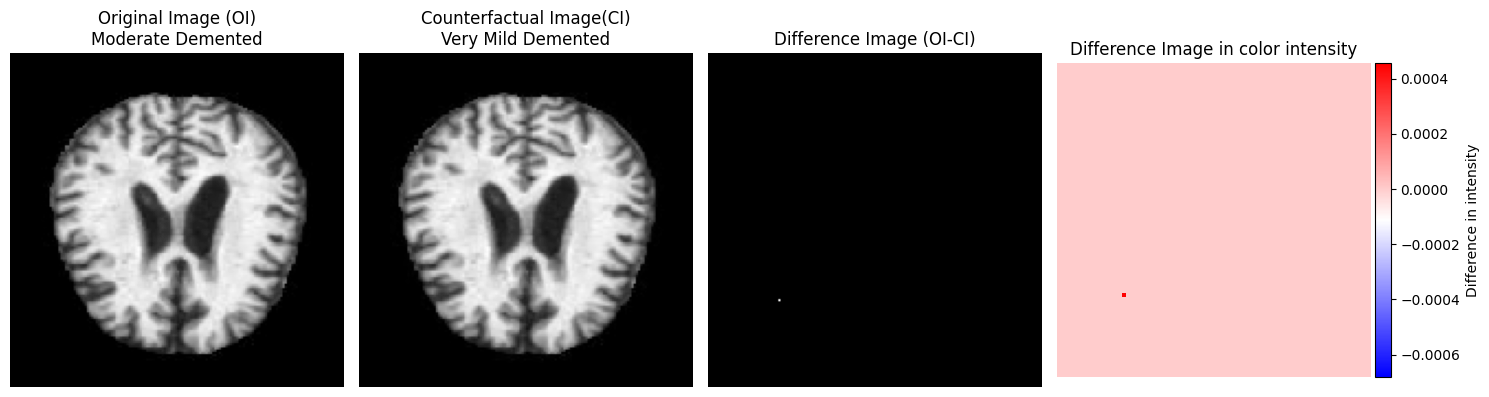

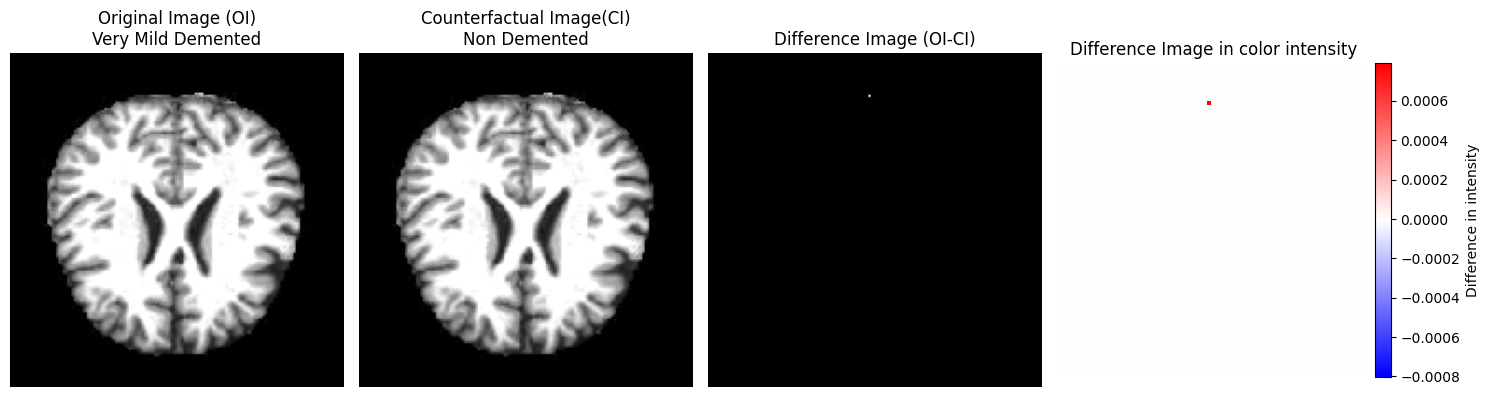

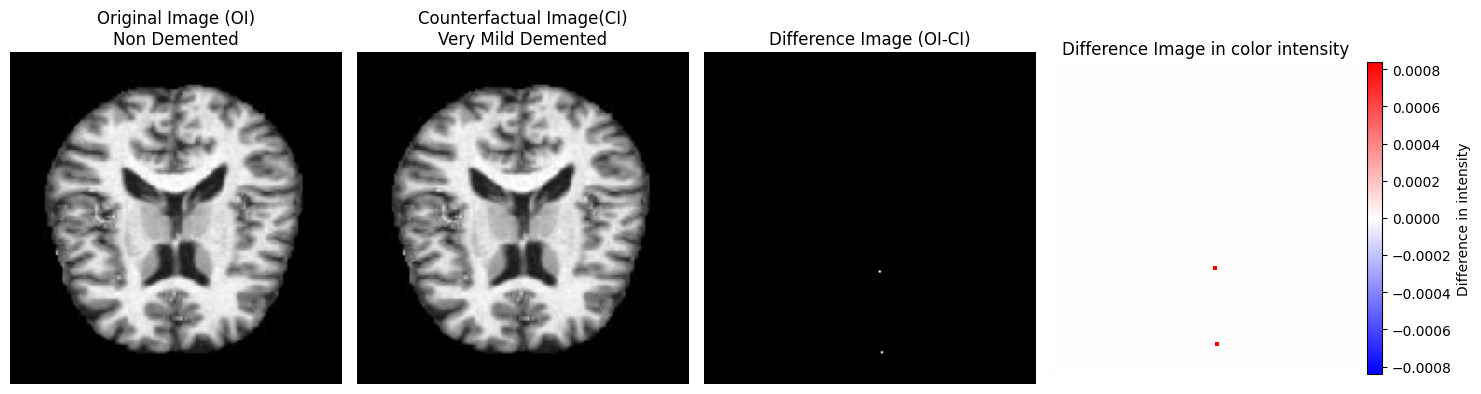

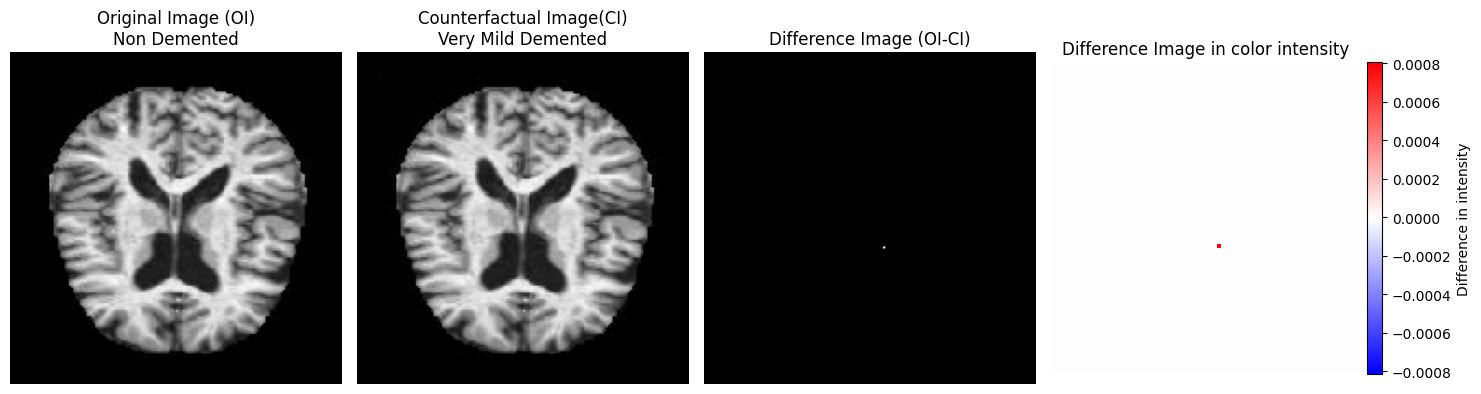

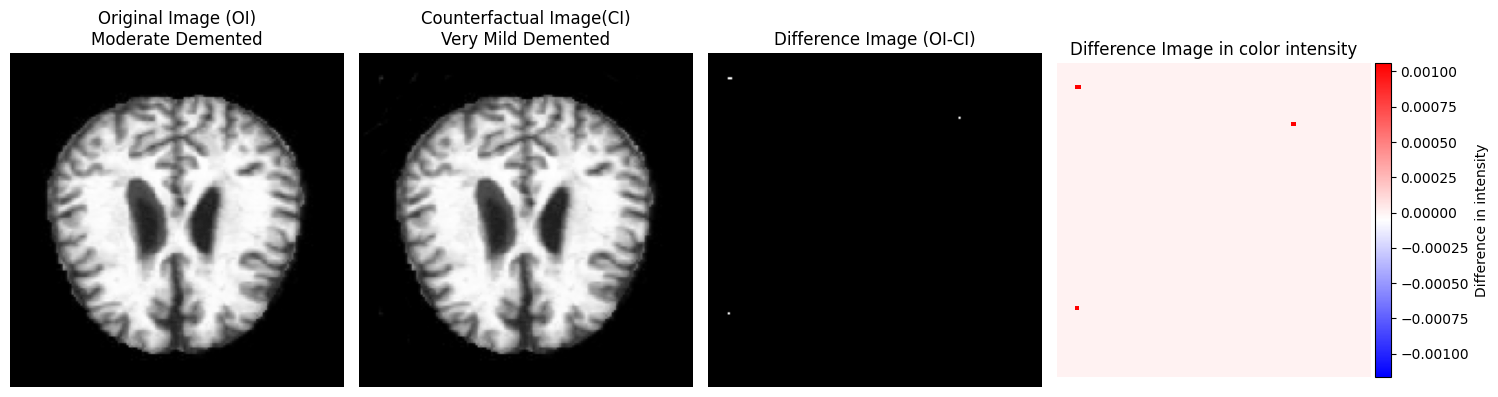

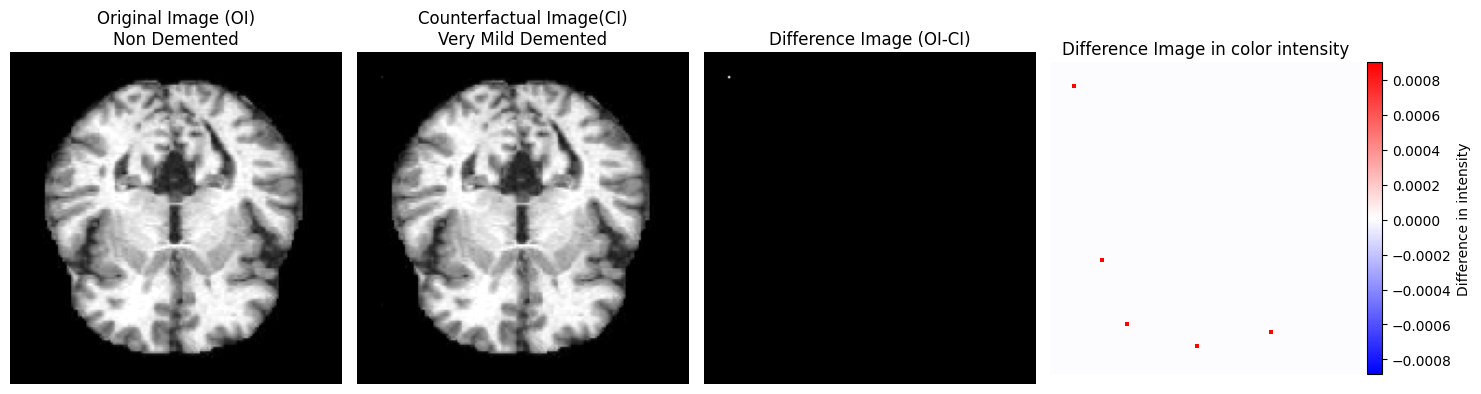

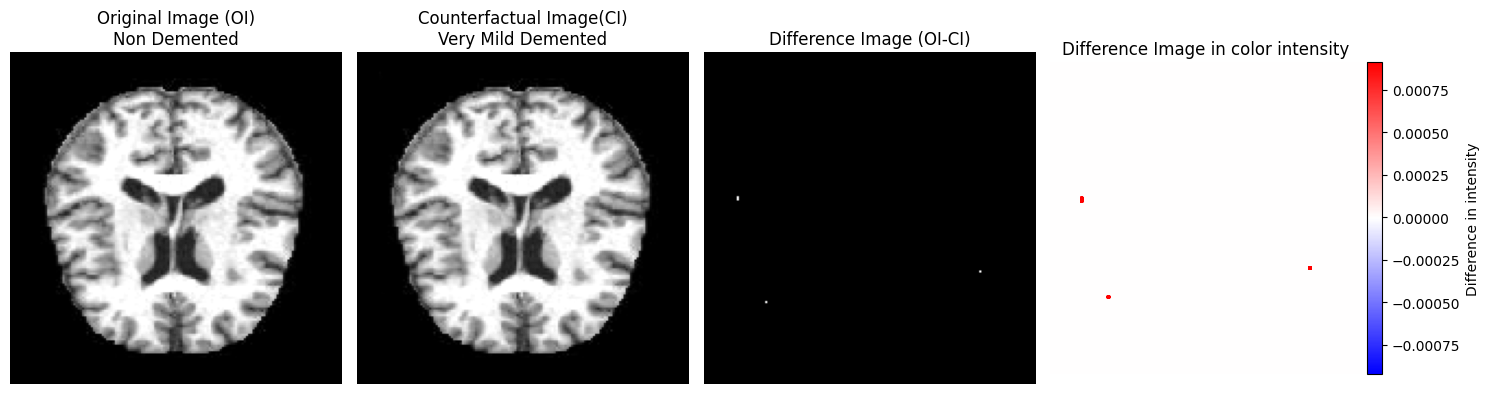

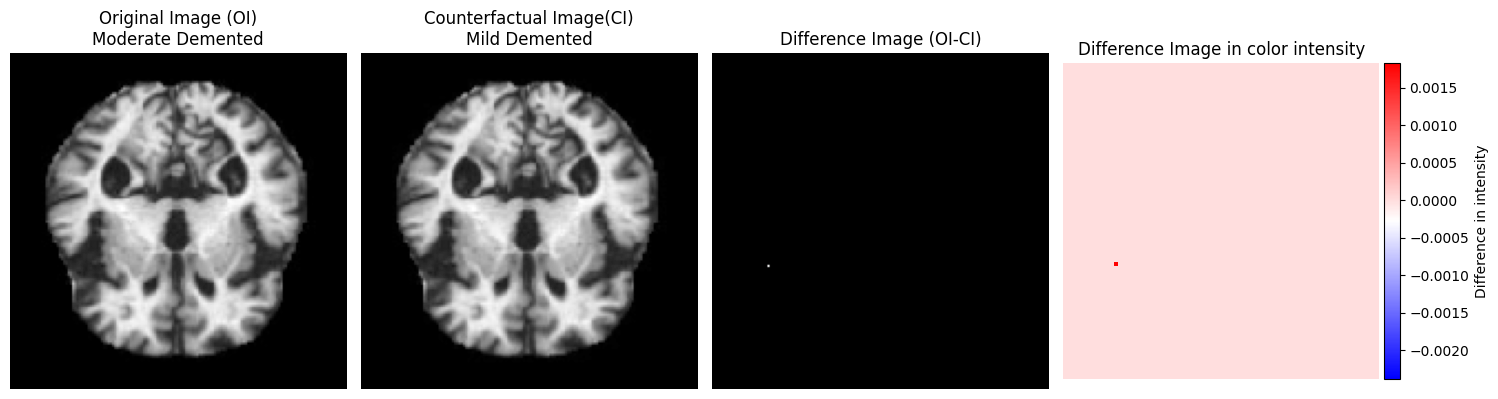

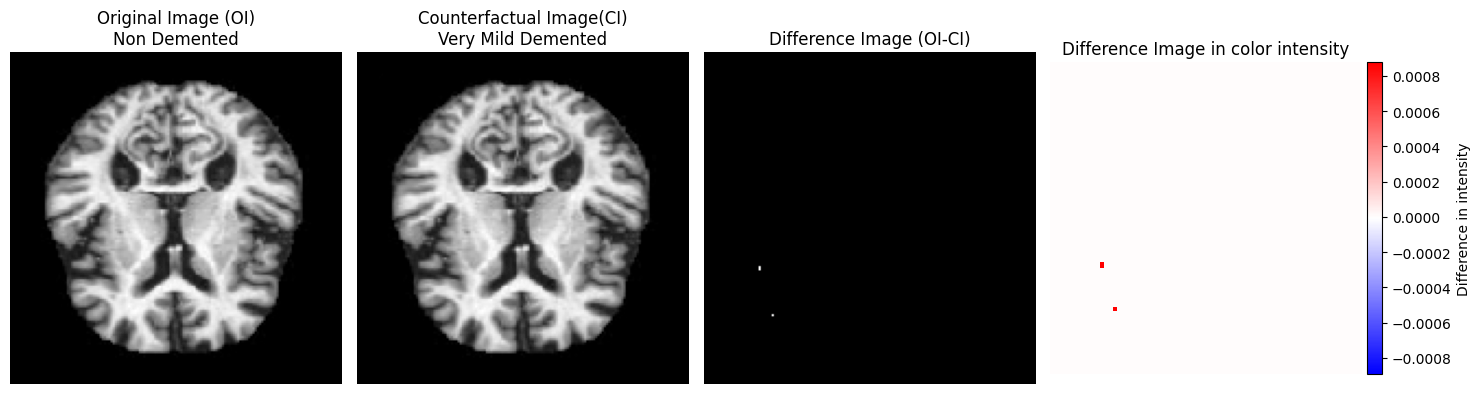

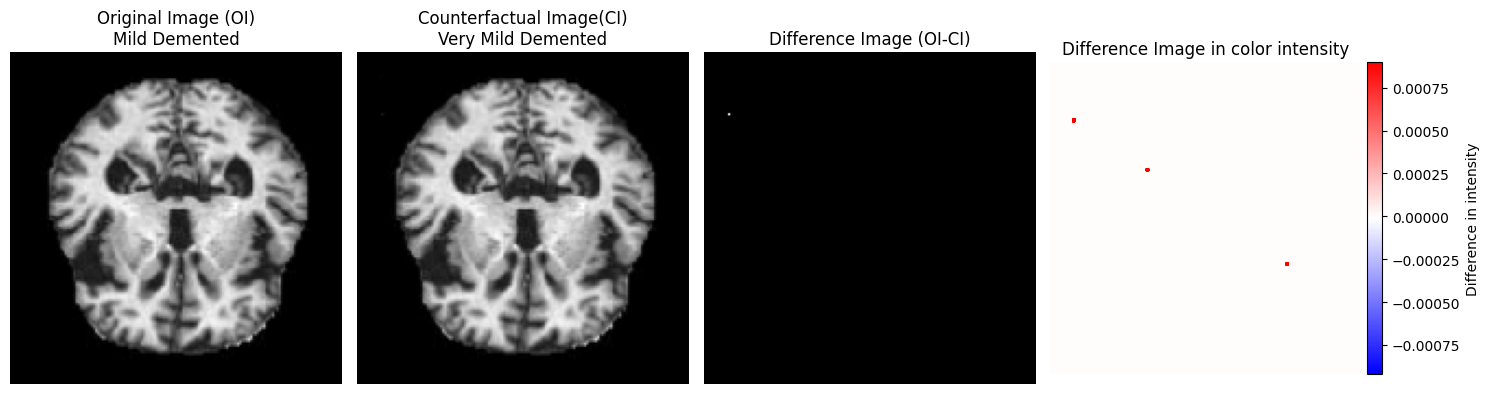

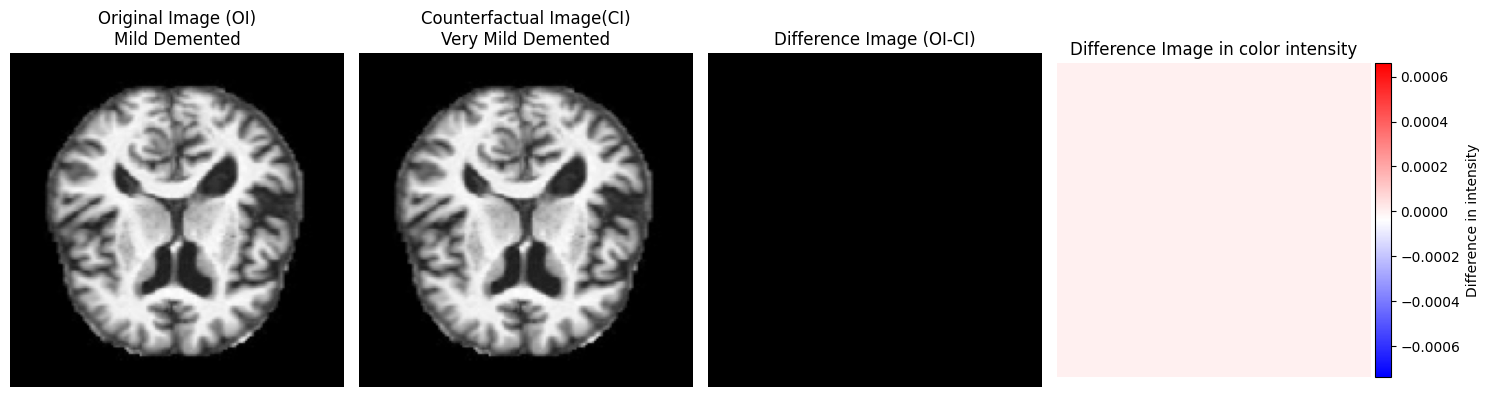

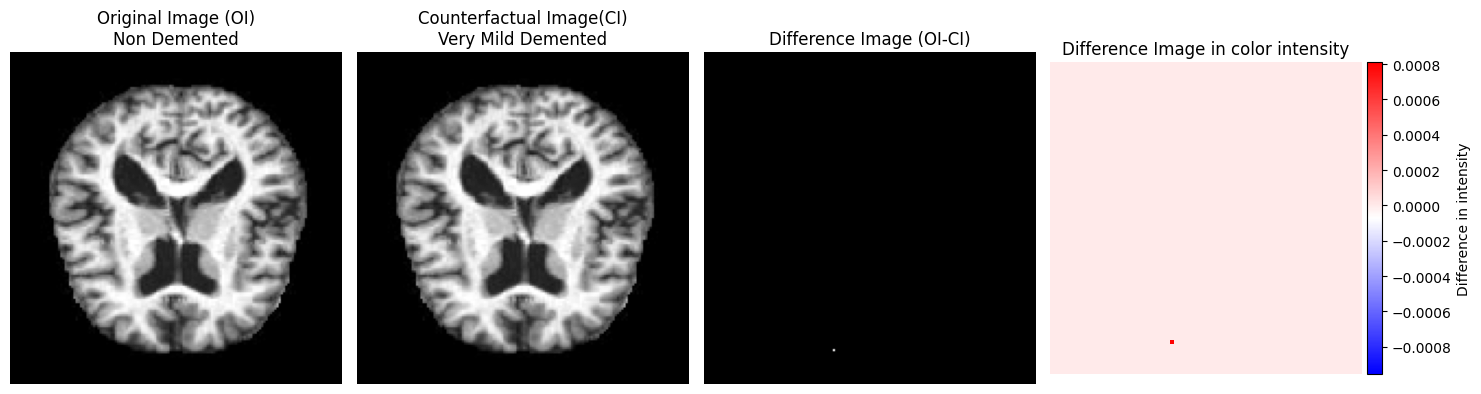

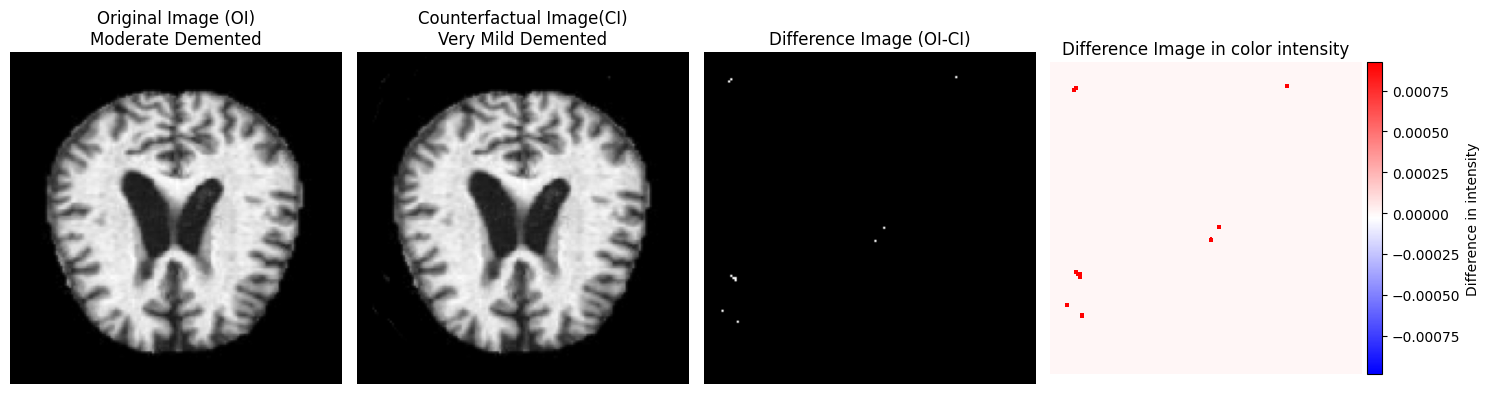

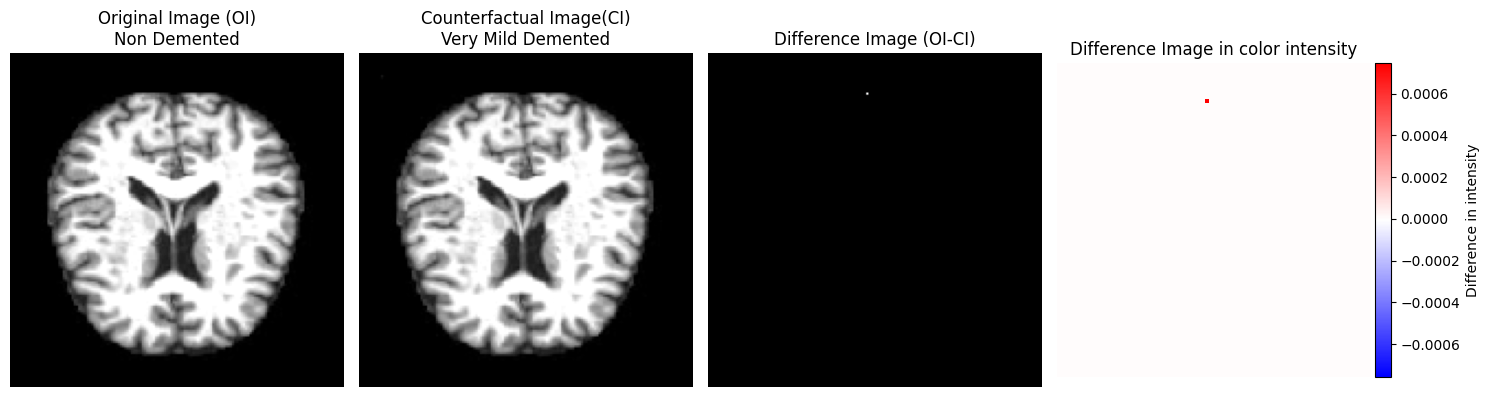

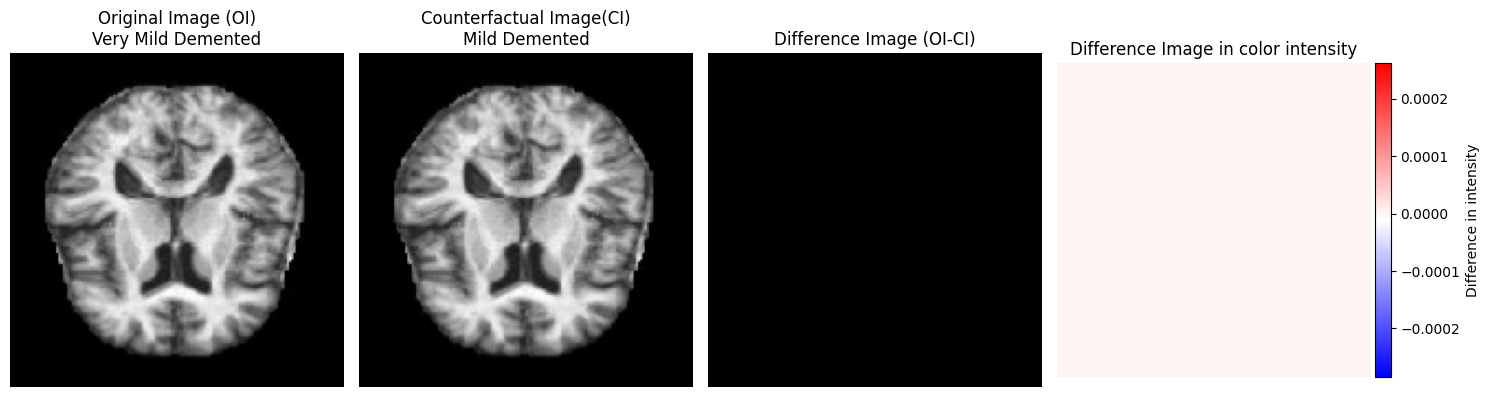

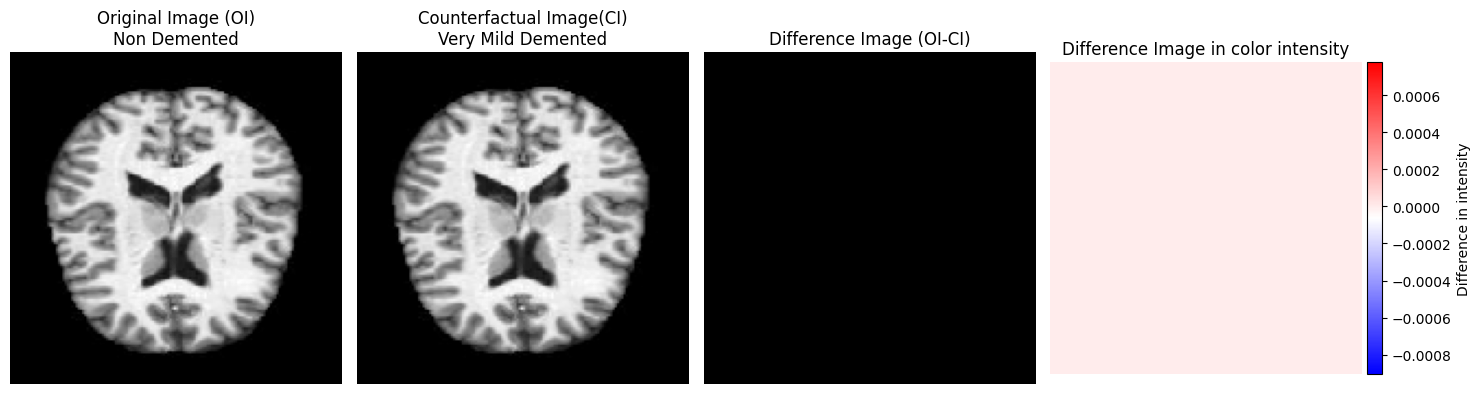

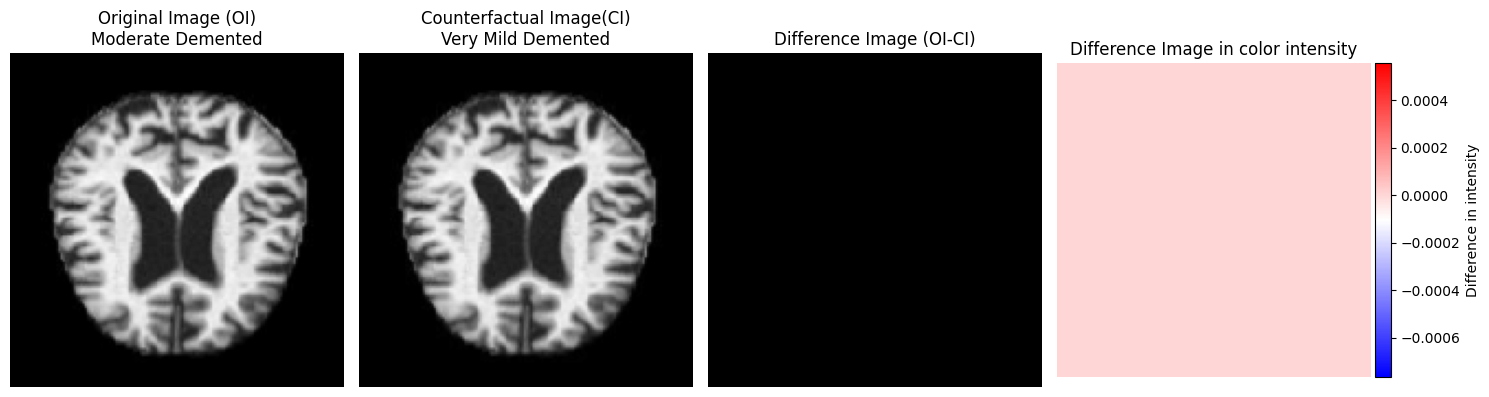

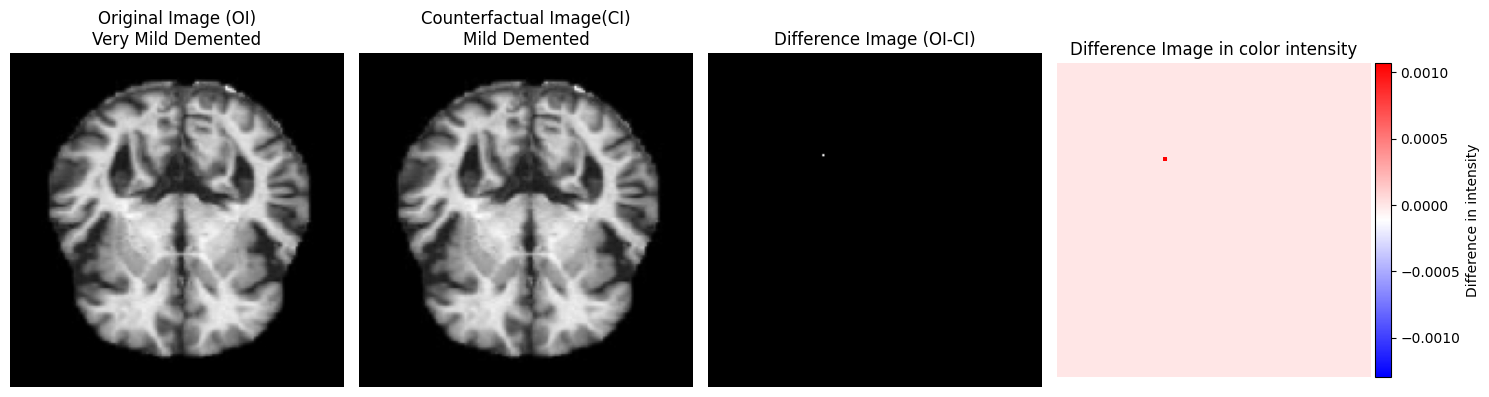

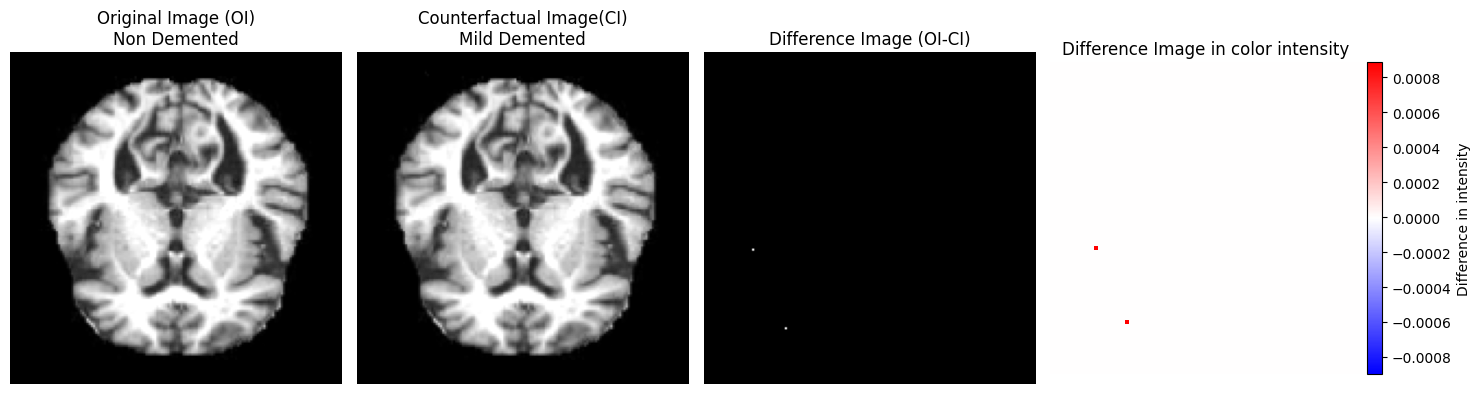

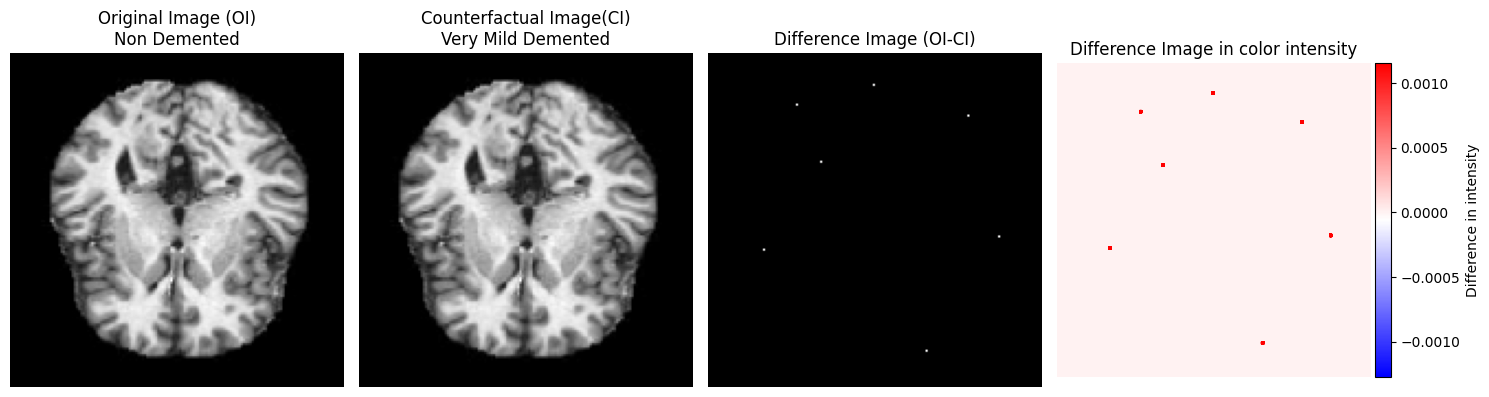

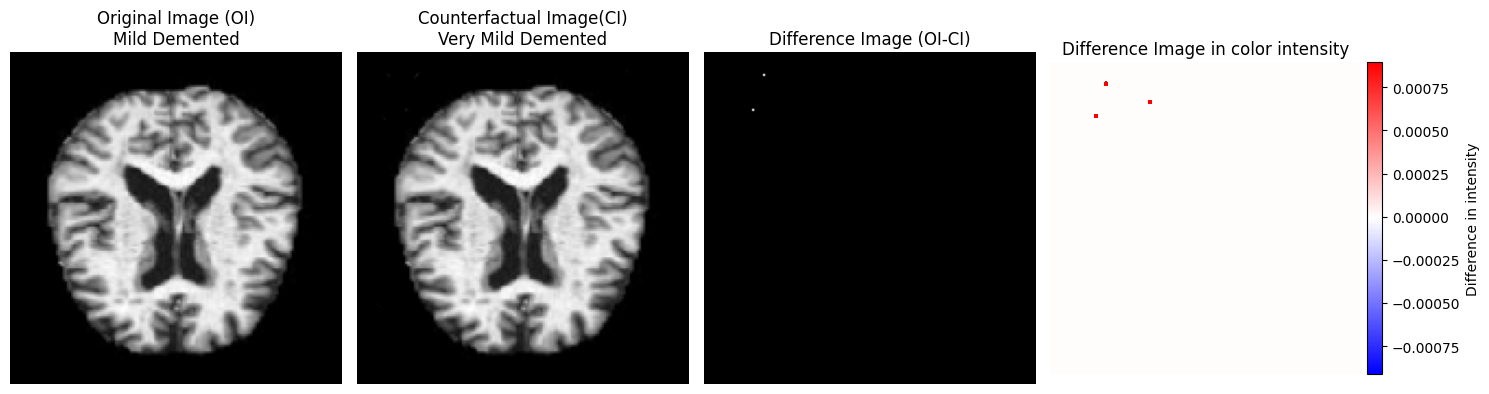

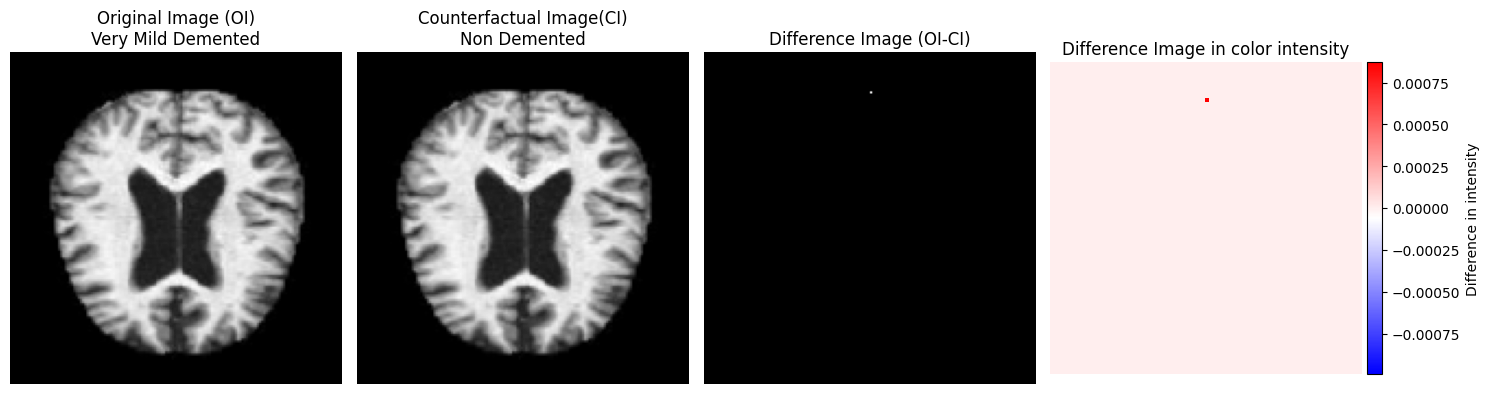

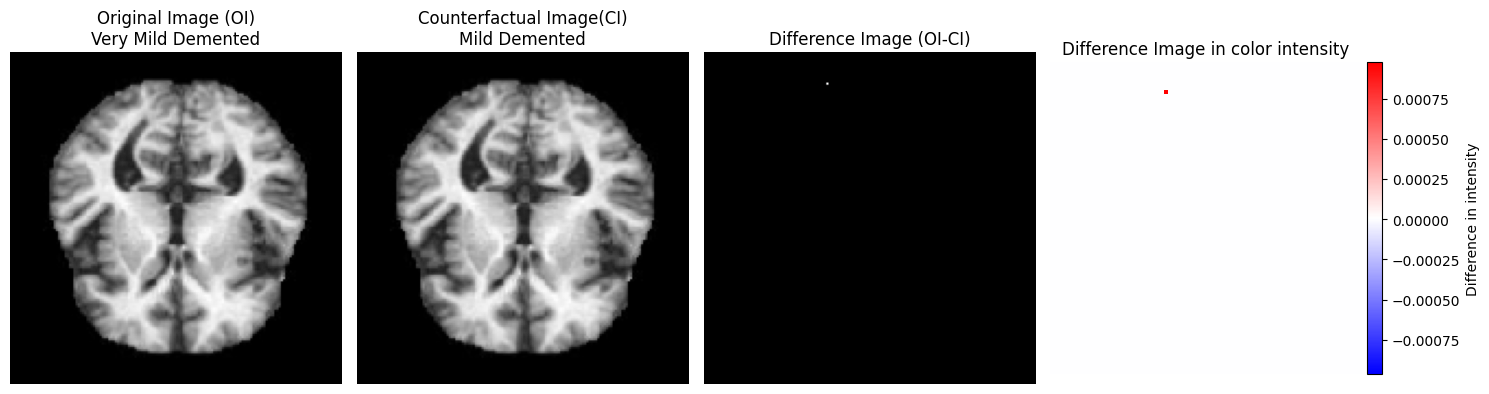

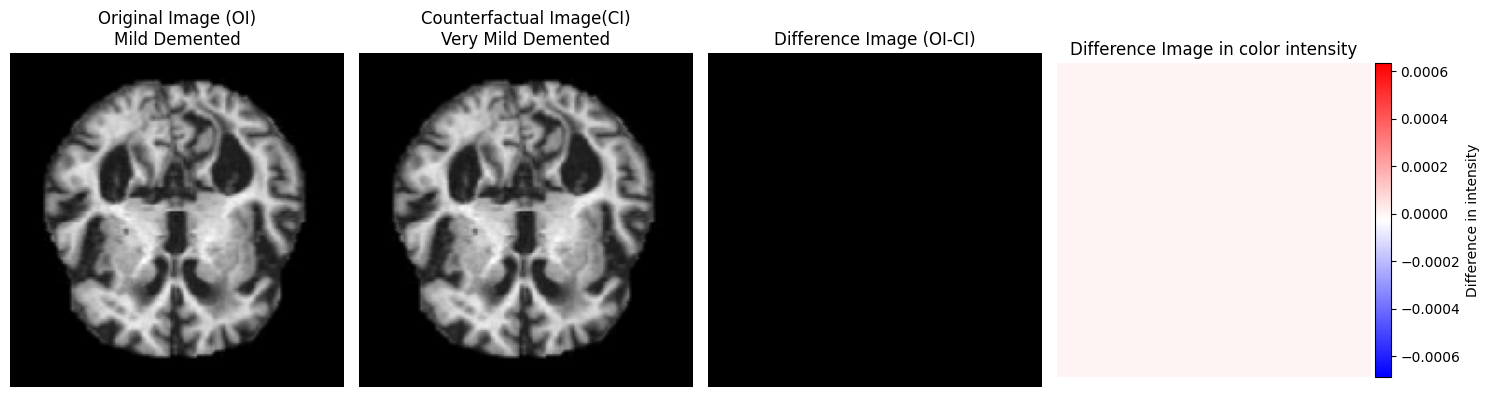

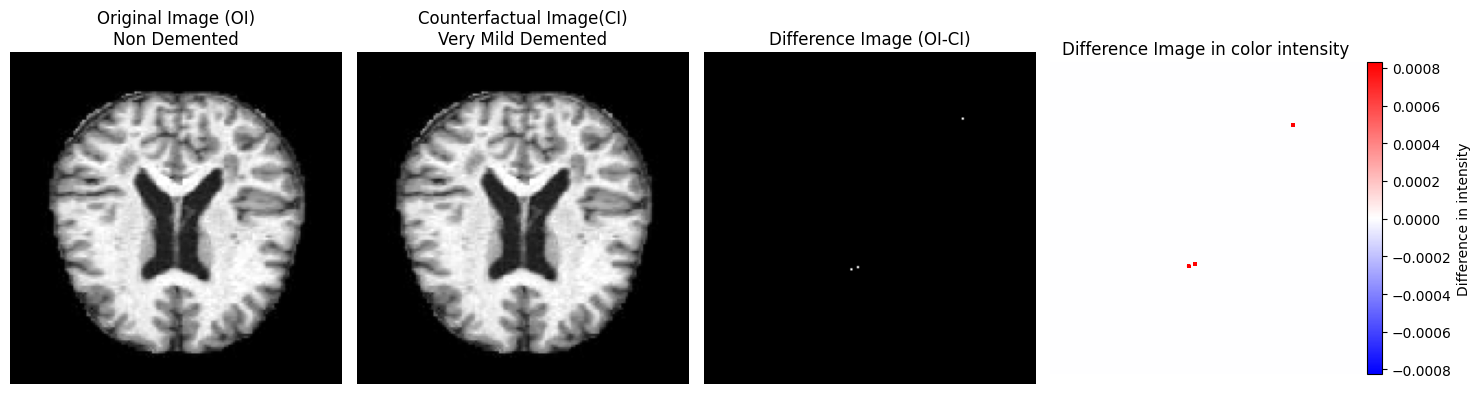

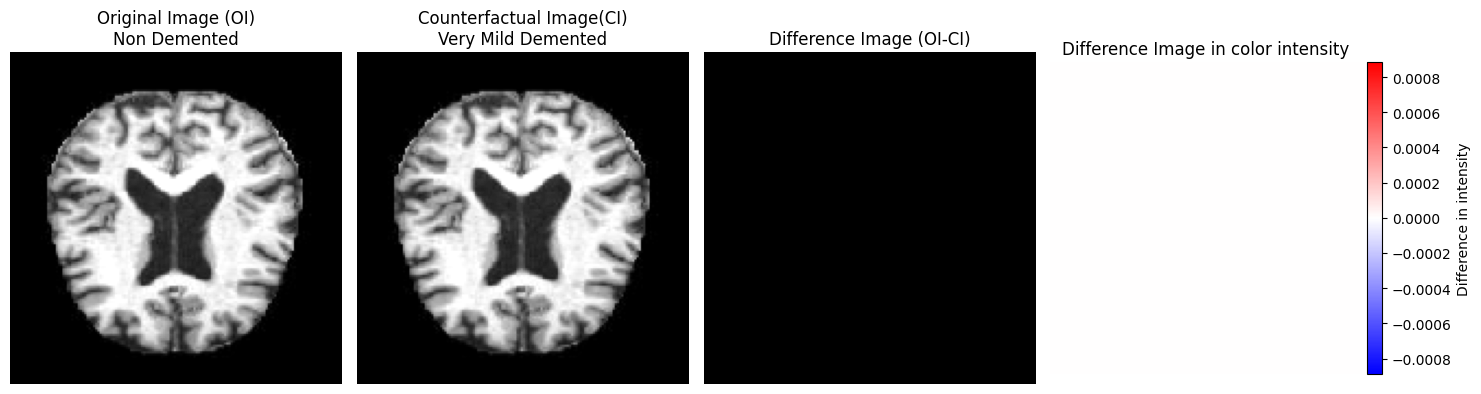

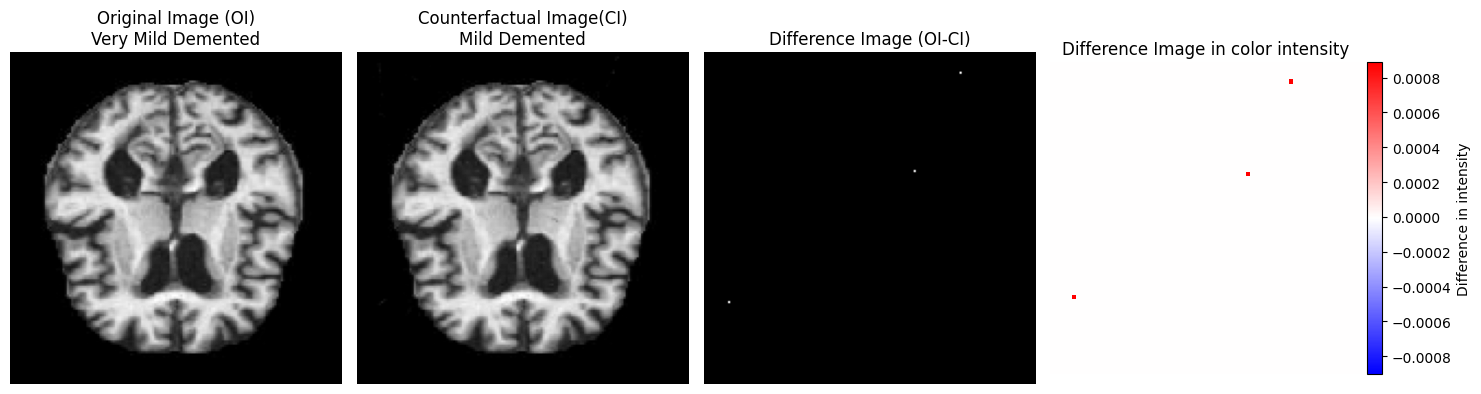

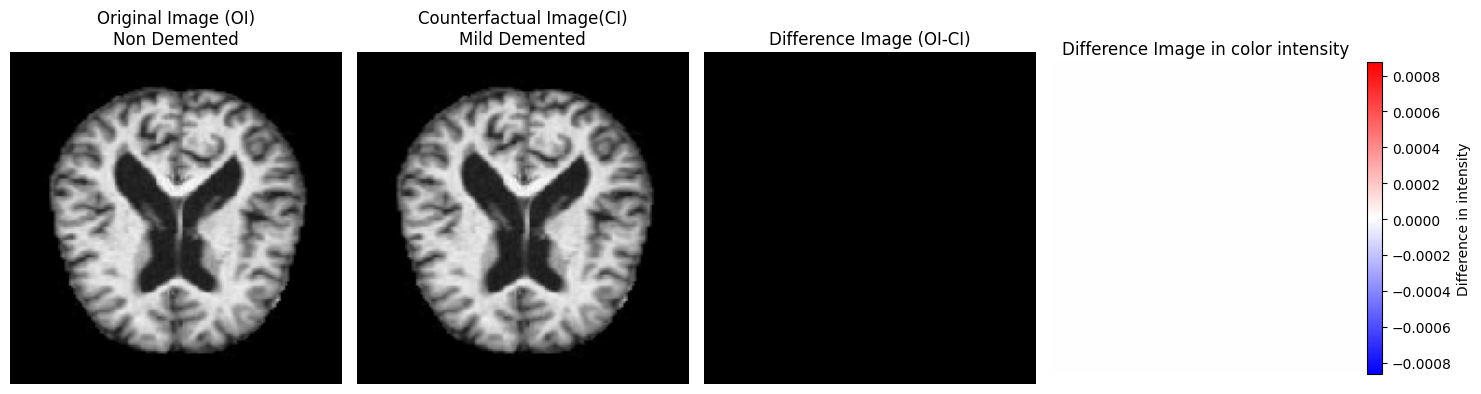

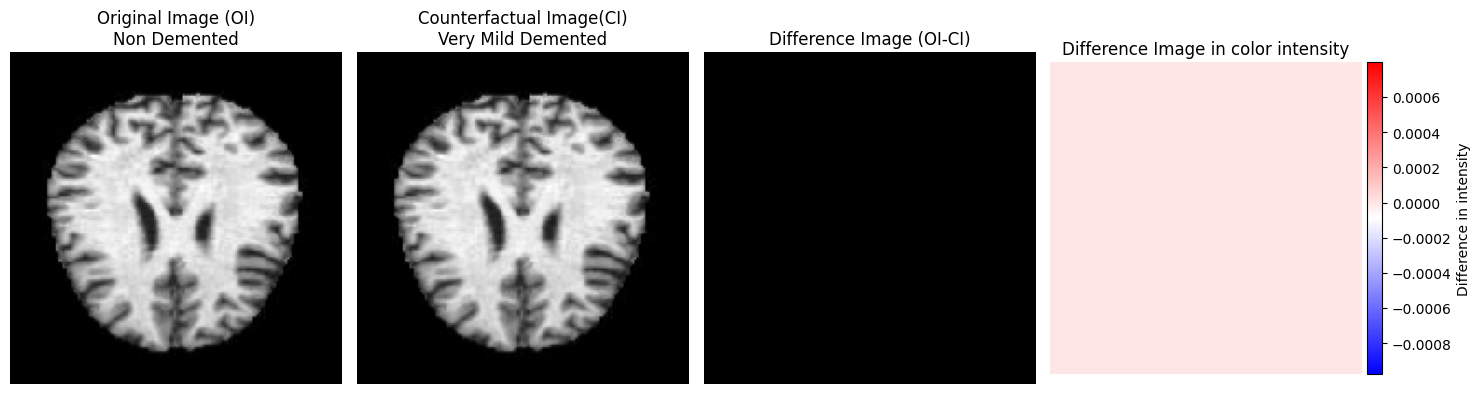

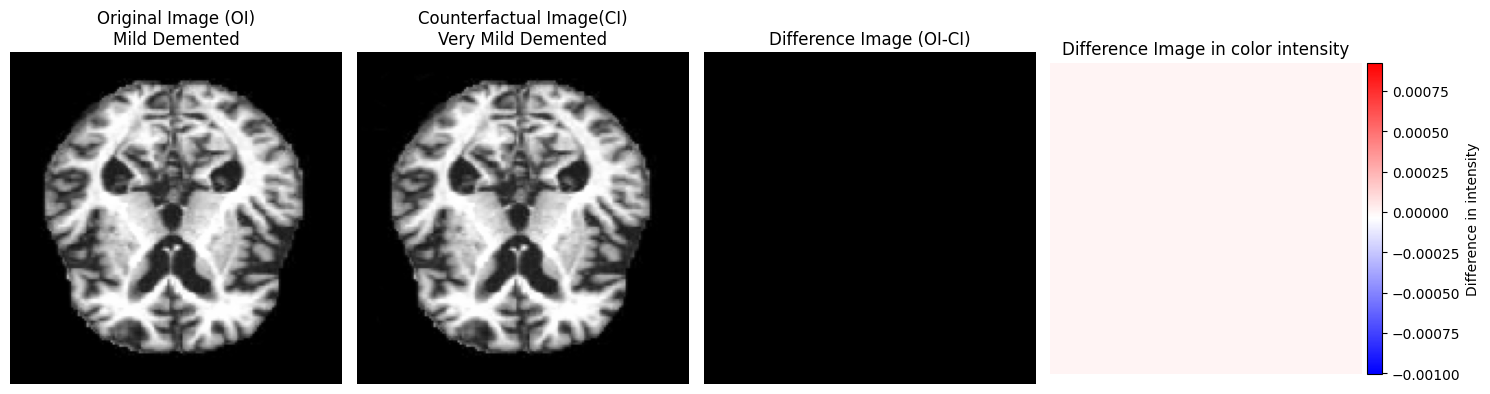

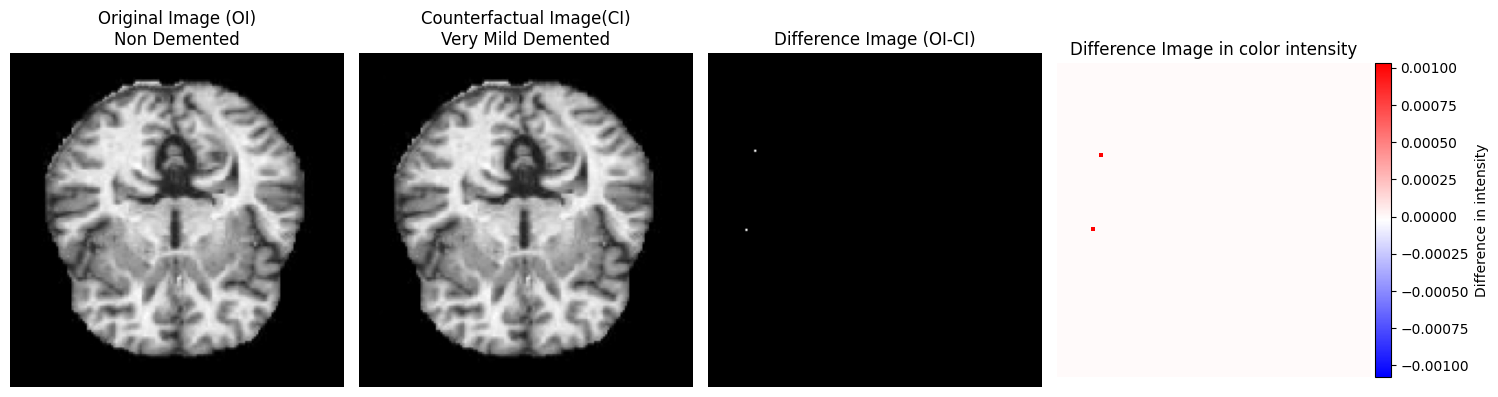

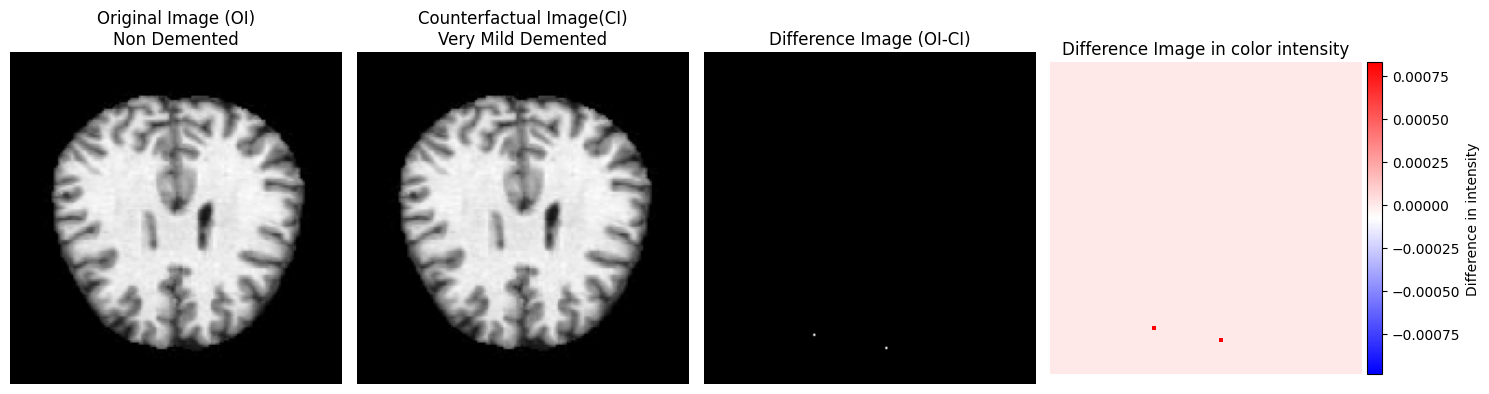

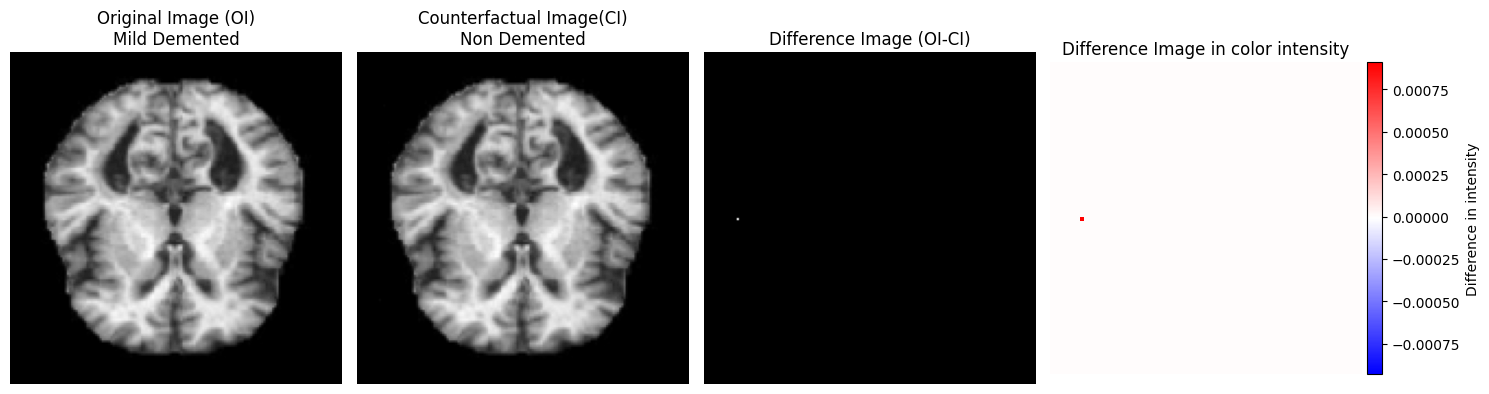

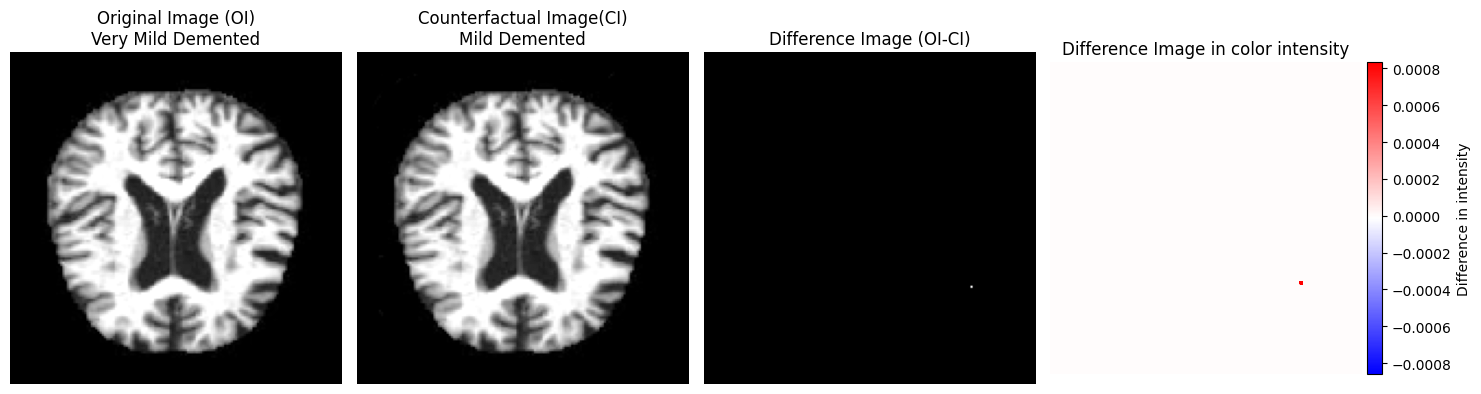

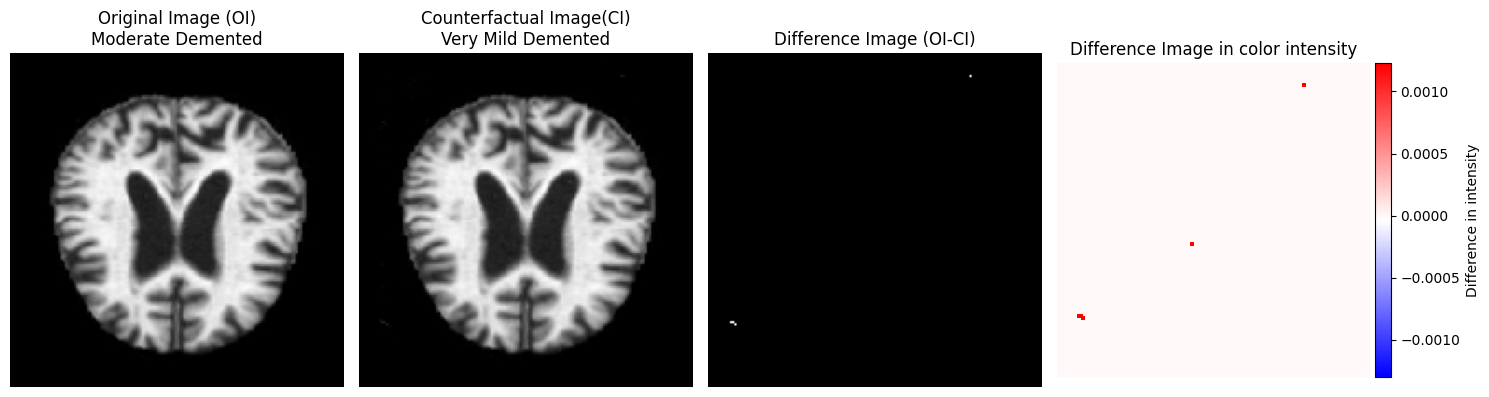

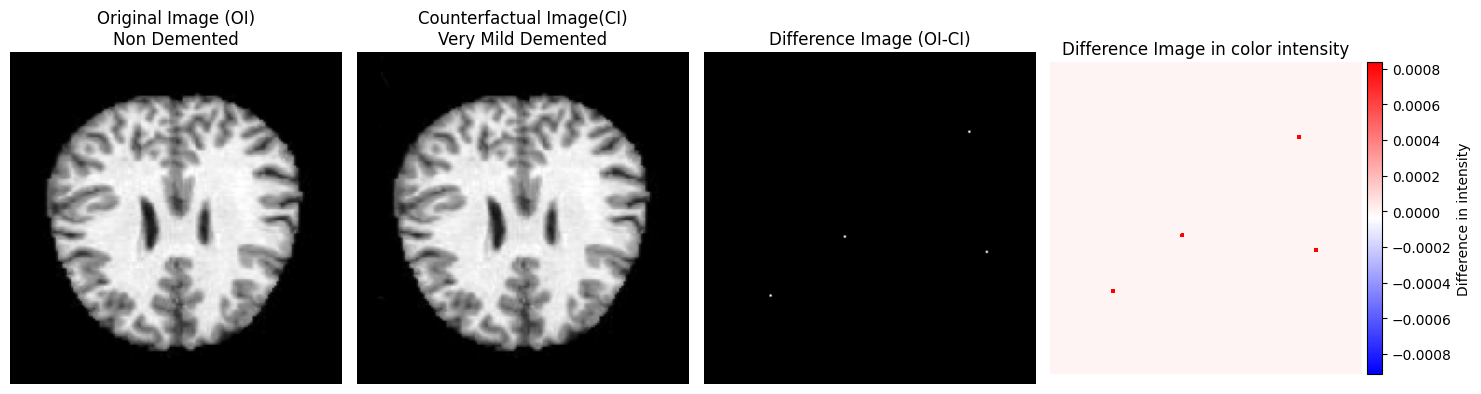

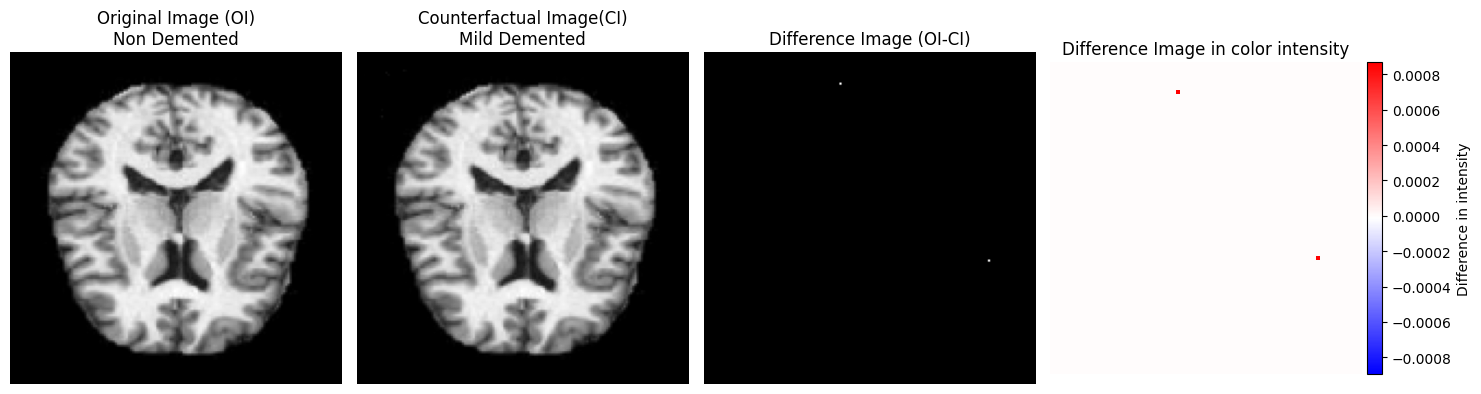

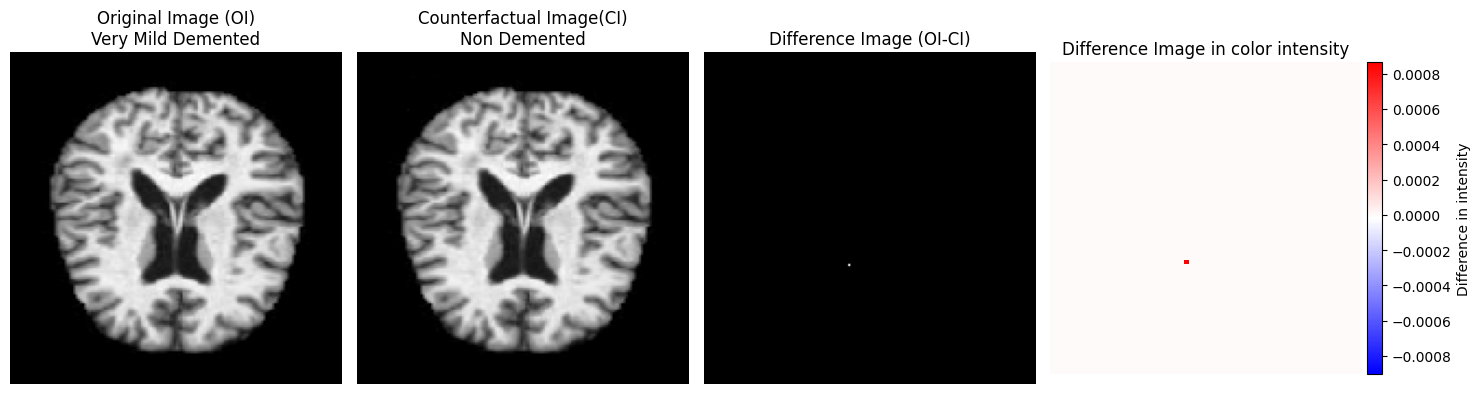

In [12]:
for i in range(50):
  plotter(i)